In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import rc, font_manager
ticks_font = font_manager.FontProperties(family='serif', style='normal',
                                         size=24, weight='normal', stretch='normal')
from scipy import optimize

In [10]:
def f1(x):
    return x[0]**2 + x[1]**2 - 25 , x[0] + x[1] - 7 

In [11]:
optimize.root(f1,[0,1])

    fjac: array([[ 0.88610944,  0.46347606],
       [-0.46347606,  0.88610944]])
     fun: array([-7.10542736e-15,  0.00000000e+00])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([ 2.14263335e-11, -1.12059573e-11])
       r: array([2.15760872, 0.38538953, 0.9269523 ])
  status: 1
 success: True
       x: array([4., 3.])

In [18]:
J2eV = 8.617333262145e-5/1.380649e-23
G = 38*1e9
nu = 0.4
h_b_ratio = np.linspace(1,2,100)
b = 2.86*1e-10

In [22]:
E_elastic = G*b**2/(np.pi*(1-nu))*np.log(h_b_ratio)*J2eV * b

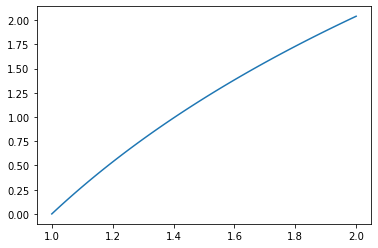

In [23]:
plt.plot(h_b_ratio,E_elastic)

In [35]:
c = np.array([0.32,0.33,0.34,0.0054])
E_wi = np.array([0.054,-0.028,-0.053,0.5])
print(sum(E_wi**2 * c)**(0.5))
print(sum(E_wi[:3]**2 * c[:3])**(0.5))
print(sum(E_wi * c))

0.05913459224514869
0.04633465225940517
-0.007280000000000001


In [29]:
(0.27**2+0.15**2+0.072**2)**(0.5)

0.3171498068736603